<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day14_Personal_Fitness_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept**

This project focuses on time series analysis and activity recognition. We'll build a tool that can identify different types of exercises from sensor data.

**Understanding Personal Fitness Tracker**

**Real-World Example: Exercise Classification**
A commercial fitness app might classify activities like:

**Walking vs. Running:**

Walking: Regular peaks at ~1-2 Hz, moderate amplitude
Running: Regular peaks at ~2-3 Hz, higher amplitude


**Weight Training:**

Repetitive patterns with pauses between sets
Different exercises show characteristic acceleration signatures
Bench press: Horizontal acceleration dominates
Squats: Vertical acceleration pattern with longer duration


**Cycling:**

Lower impact accelerometer readings
Regular rotational patterns in gyroscope
Consistent elevated heart rate




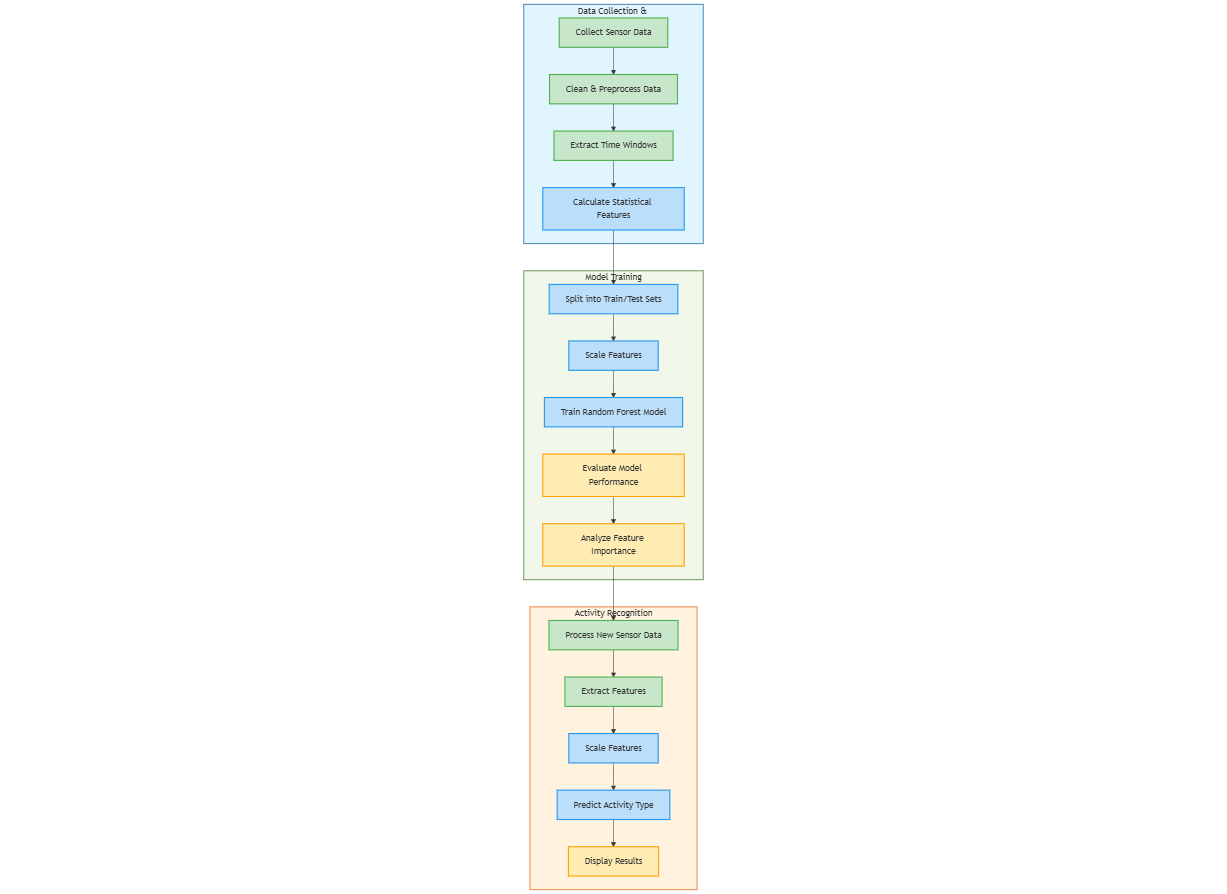


**Implementation in Real Systems**

**Commercial Examples**


*   **Fitbit's SmartTrack:** Automatically recognizes activities like walking, running, cycling after about 15 minutes of activity
*   **Apple Watch Workout Detection:** Uses multiple sensors to prompt users when it detects a workout has started



*   **Garmin's Move IQ:** Identifies and categorizes activities into walking, running, biking, swimming, and elliptical training







#Lest begin the Implmentation

**Install and import necessary libraries**

In [1]:
# Install required libraries
!pip install numpy pandas scikit-learn matplotlib seaborn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import zipfile
import io
import requests
from google.colab import files

**Get the Human Activity Recognition dataset**

In [2]:
# Download the UCI HAR dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip 'UCI HAR Dataset.zip'

--2025-04-27 02:12:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [        <=>         ]  58.17M  39.4MB/s    in 1.5s    

2025-04-27 02:12:29 (39.4 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.t

**Load and explore the data**

In [3]:
# Read activity labels and features
activity_labels = pd.read_csv('UCI HAR Dataset/activity_labels.txt',
                             sep=' ',
                             header=None,
                             names=['label_id', 'activity_name'])

features = pd.read_csv('UCI HAR Dataset/features.txt',
                      sep=' ',
                      header=None,
                      names=['feature_id', 'feature_name'])

# Display activity types in our dataset
print("Activities in our dataset:")
print(activity_labels)

# Display the first few feature names (out of 561 total features)
print("\nSample features from our dataset (showing first 10 of 561):")
print(features.head(10))

Activities in our dataset:
   label_id       activity_name
0         1             WALKING
1         2    WALKING_UPSTAIRS
2         3  WALKING_DOWNSTAIRS
3         4             SITTING
4         5            STANDING
5         6              LAYING

Sample features from our dataset (showing first 10 of 561):
   feature_id       feature_name
0           1  tBodyAcc-mean()-X
1           2  tBodyAcc-mean()-Y
2           3  tBodyAcc-mean()-Z
3           4   tBodyAcc-std()-X
4           5   tBodyAcc-std()-Y
5           6   tBodyAcc-std()-Z
6           7   tBodyAcc-mad()-X
7           8   tBodyAcc-mad()-Y
8           9   tBodyAcc-mad()-Z
9          10   tBodyAcc-max()-X


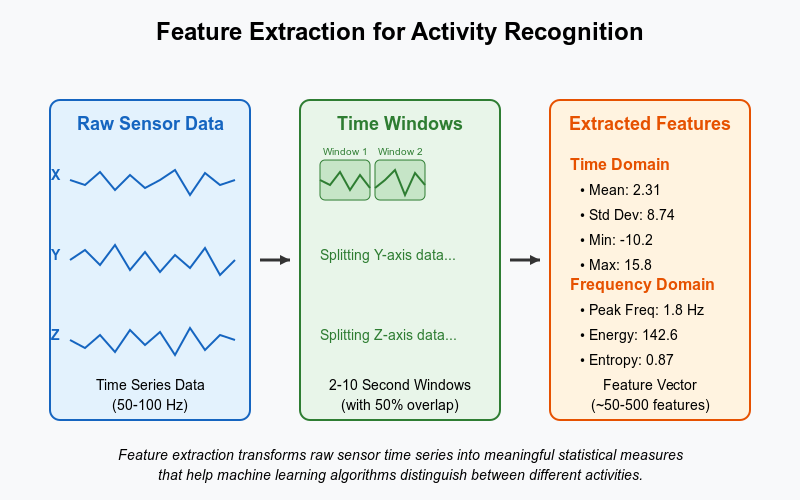

**Load training data**

In [4]:
# Load training data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt',
                     delim_whitespace=True,
                     header=None)
X_train.columns = features['feature_name']

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt',
                     header=None,
                     names=['activity'])

# Load test data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt',
                    delim_whitespace=True,
                    header=None)
X_test.columns = features['feature_name']

y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt',
                    header=None,
                    names=['activity'])

# Map numeric labels to activity names
y_train_labels = y_train['activity'].map(activity_labels.set_index('label_id')['activity_name'])
y_test_labels = y_test['activity'].map(activity_labels.set_index('label_id')['activity_name'])

# Print dataset shapes
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of activities: {y_train['activity'].nunique()}")

# Show count of each activity in training data
print("\nActivity distribution in training data:")
activity_counts = y_train_labels.value_counts()
print(activity_counts)

# Examine first few rows of our feature data
print("\nFirst 5 rows and 10 columns of sensor data:")
print(X_train.iloc[:5, :10])

<ipython-input-4-249e240db5d1>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt',
<ipython-input-4-249e240db5d1>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt',


Training set shape: (7352, 561)
Test set shape: (2947, 561)
Number of activities: 6

Activity distribution in training data:
activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

First 5 rows and 10 columns of sensor data:
feature_name  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0                      0.288585          -0.020294          -0.132905   
1                      0.278419          -0.016411          -0.123520   
2                      0.279653          -0.019467          -0.113462   
3                      0.279174          -0.026201          -0.123283   
4                      0.276629          -0.016570          -0.115362   

feature_name  tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  \
0                    -0.995279         -0.983111         -0.913526   
1                    -0.998245         -0.975300      

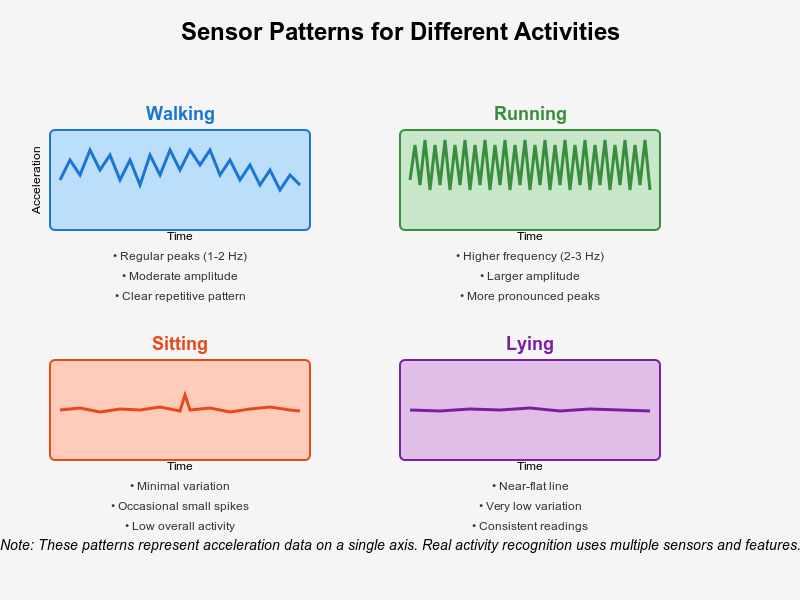

**Data preprocessing**

In [5]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data has been scaled to have zero mean and unit variance")

Data has been scaled to have zero mean and unit variance


**Train a Random Forest classifier**

In [6]:
# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train['activity'])

print("Random Forest model has been trained!")

Random Forest model has been trained!


**Evaluate the model**

Model accuracy: 92.60%

Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.89      0.90       491
          STANDING       0.90      0.92      0.91       532
           WALKING       0.89      0.96      0.92       496
WALKING_DOWNSTAIRS       0.97      0.86      0.91       420
  WALKING_UPSTAIRS       0.89      0.90      0.90       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947



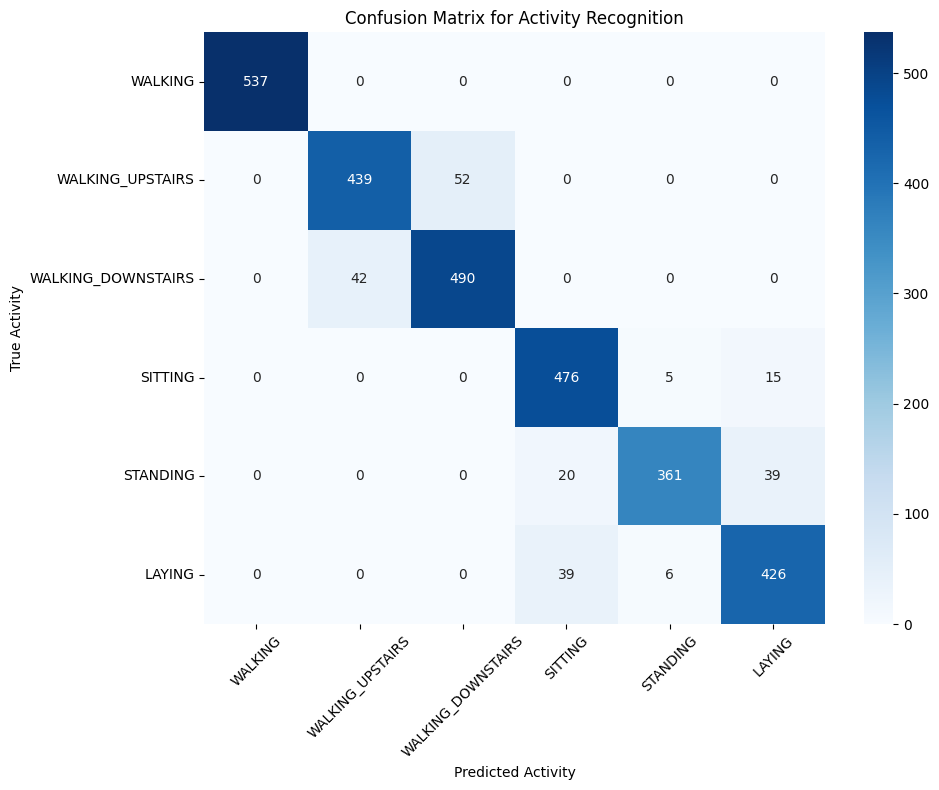

In [7]:
# Make predictions on test data
y_pred = model.predict(X_test_scaled)

# Convert numeric predictions to activity names
y_pred_labels = pd.Series(y_pred).map(activity_labels.set_index('label_id')['activity_name'])

# Calculate accuracy
accuracy = (y_pred == y_test['activity']).mean() * 100
print(f"Model accuracy: {accuracy:.2f}%")

# Show detailed performance metrics
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Create and plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels['activity_name'],
            yticklabels=activity_labels['activity_name'])
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')
plt.title('Confusion Matrix for Activity Recognition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Feature importance analysis**

Top 20 most important features for activity recognition:
                             Feature  Importance
40              tGravityAcc-mean()-X    0.037912
49               tGravityAcc-max()-X    0.030716
558             angle(X,gravityMean)    0.028821
41              tGravityAcc-mean()-Y    0.027978
56            tGravityAcc-energy()-X    0.024747
559             angle(Y,gravityMean)    0.024599
52               tGravityAcc-min()-X    0.023671
53               tGravityAcc-min()-Y    0.021571
50               tGravityAcc-max()-Y    0.020367
57            tGravityAcc-energy()-Y    0.015491
83              tBodyAccJerk-std()-X    0.013044
560             angle(Z,gravityMean)    0.012365
504                fBodyAccMag-mad()    0.011245
214             tGravityAccMag-std()    0.011035
389  fBodyAccJerk-bandsEnergy()-1,16    0.010798
58            tGravityAcc-energy()-Z    0.010371
265                fBodyAcc-mean()-X    0.010175
353             fBodyAccJerk-max()-X    0.010148
403  fBodyAc

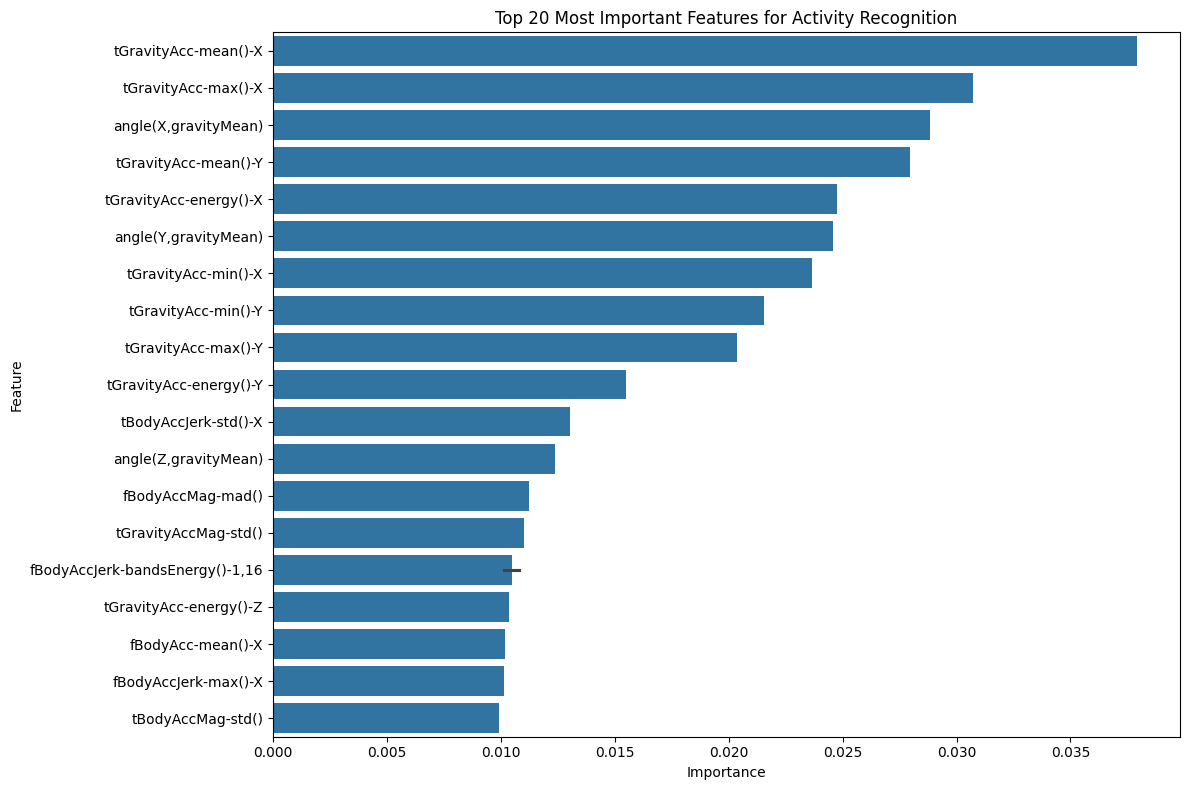

In [8]:
# Get feature importance from our model
feature_importances = model.feature_importances_
feature_names = features['feature_name']

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and display top 20
top_features = feature_importance_df.sort_values('Importance', ascending=False).head(20)
print("Top 20 most important features for activity recognition:")
print(top_features)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Most Important Features for Activity Recognition')
plt.tight_layout()
plt.show()

**Make predictions on new data**

In [9]:
def predict_activity(sensor_data):
    """
    Predict activity based on sensor data

    Parameters:
    sensor_data: DataFrame or array with the same 561 features as the training data

    Returns:
    Predicted activity name
    """
    # Make sure input has correct shape
    if isinstance(sensor_data, pd.DataFrame):
        if sensor_data.shape[1] != X_train.shape[1]:
            raise ValueError(f"Input must have {X_train.shape[1]} features")
        data = sensor_data.values
    else:
        data = np.array(sensor_data).reshape(1, -1)

    # Scale the data
    scaled_data = scaler.transform(data)

    # Make prediction
    prediction = model.predict(scaled_data)

    # Convert to label
    activity_name = activity_labels.loc[activity_labels['label_id'] == prediction[0], 'activity_name'].values[0]

    return activity_name

# Test with a random example from test set
random_index = np.random.randint(0, len(X_test))
random_example = X_test.iloc[random_index:random_index+1]
true_activity = y_test_labels.iloc[random_index]
predicted_activity = predict_activity(random_example)

print(f"True activity: {true_activity}")
print(f"Predicted activity: {predicted_activity}")

True activity: WALKING_UPSTAIRS
Predicted activity: WALKING


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**Visualize the sensor data patterns**

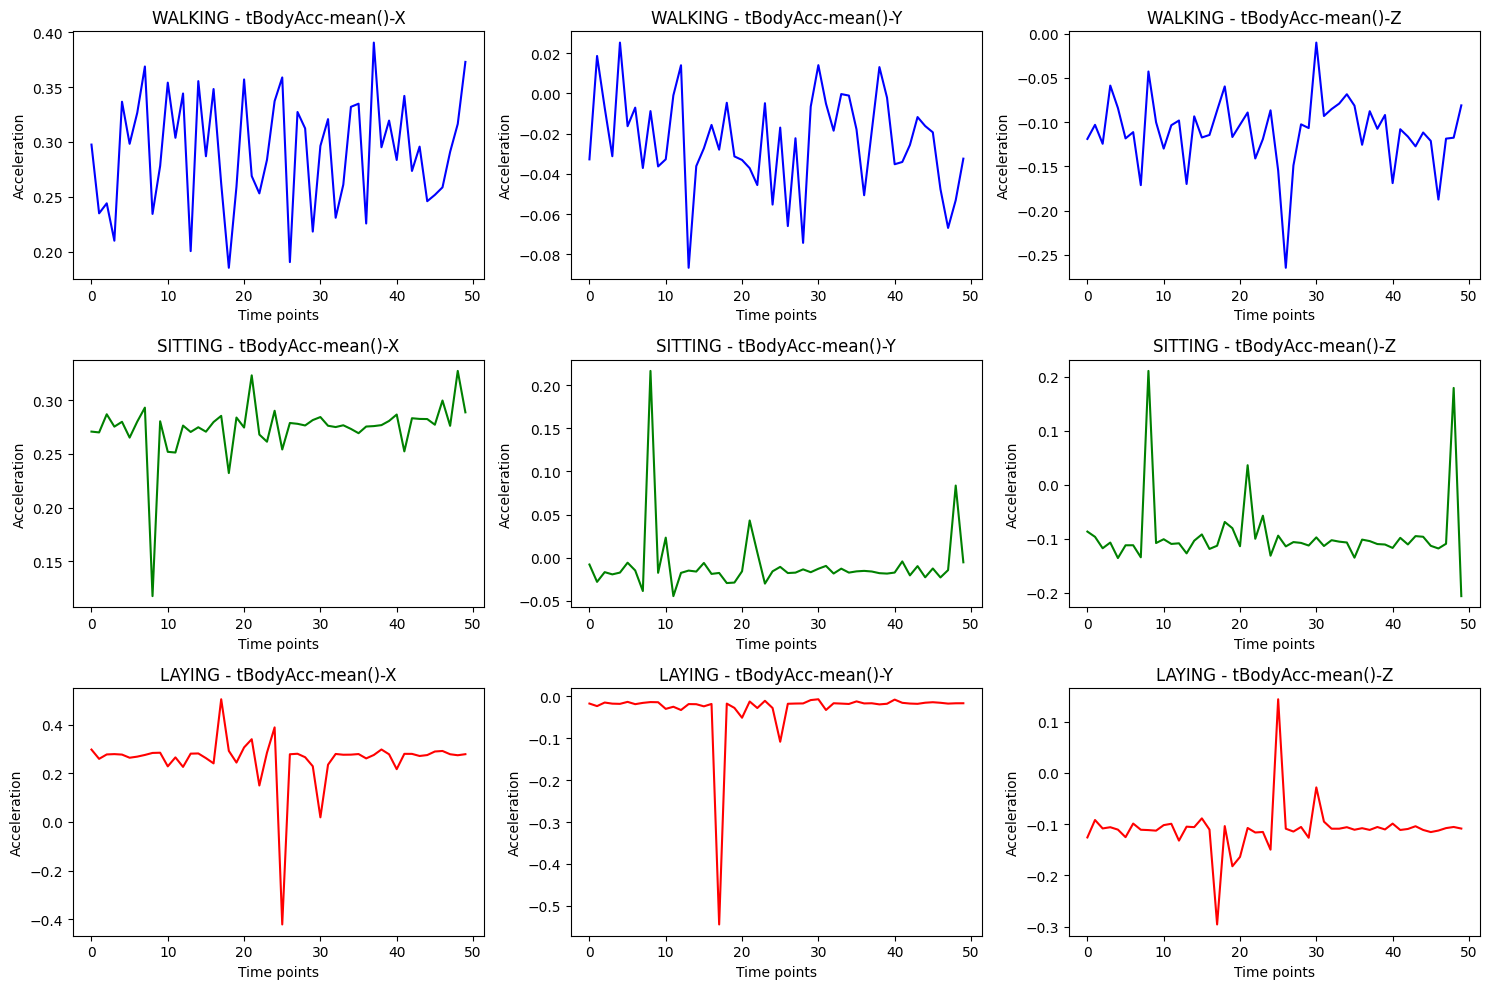

In [10]:
# Get raw accelerometer data
subject_train = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None, names=['subject'])
combined_train = pd.concat([subject_train, y_train, y_train_labels.rename('activity_name'), X_train], axis=1)

# Select accelerometer data columns
acc_columns = [col for col in X_train.columns if 'Acc' in col and 'mean' in col and not 'Jerk' in col][:3]

# Function to get data for specific activities
def get_activity_data(activity, n_samples=100):
    activity_data = combined_train[combined_train['activity_name'] == activity].sample(n_samples)
    return activity_data

# Select a few activities to visualize
activities = ['WALKING', 'SITTING', 'LAYING']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(15, 10))

for i, (activity, color) in enumerate(zip(activities, colors)):
    activity_data = get_activity_data(activity)

    for j, column in enumerate(acc_columns):
        plt.subplot(3, 3, i*3 + j + 1)
        plt.plot(activity_data[column].values[:50], color=color)
        plt.title(f"{activity} - {column}")
        plt.xlabel('Time points')
        plt.ylabel('Acceleration')

plt.tight_layout()
plt.show()

**Save the model for future use**

In [11]:
import pickle

# Save the model and scaler
with open('fitness_activity_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('fitness_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Download the model files to your computer
files.download('fitness_activity_model.pkl')
files.download('fitness_scaler.pkl')

print("Model and scaler saved and ready for download!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model and scaler saved and ready for download!
